In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import fitsio as ft
from glob import glob

import sys
sys.path.append('/home/mehdi/github/LSSutils')
from lssutils.utils import histogram_cell, make_overdensity

In [2]:
from lssutils.lab import AnaFast

In [28]:
def makehp(hpix, value, nside):
    res_ = np.zeros(12*nside*nside)
    res_[hpix] = value
    return res_

#I/O of systematic maps
def read_img_map(filename, nside=1024):
    d = ft.read(filename)
    m = np.zeros(12*nside*nside)
    v = d['weight'] / np.median(d['weight']) # normalize by the median
    v = v.clip(0.5, 2.0)                             # clip the extremes
    v = v / v.mean()                                 # normalize to one
    m[d['hpix']] = v
    return m

class NonlinEnsemble:
    def __init__(self):
        
        files = glob('/home/mehdi/data/tanveer/elg_mse_snapshots/windows/window_*.fits')
        files = np.random.permutation(files)
        print(len(files))
        
        self.ws = []
        for file_i in files:
            self.ws.append(read_img_map(file_i))
            print('.', end='')
        print(np.array(self.ws).shape)
        
        
        
    def __call__(self):
        #w_s = model(self.xs, self.chains[ix, :])
        w_ = np.mean(self.ws, axis=0)
        print(w_.min(), w_.max())
        return w_

def plot_bin(cl, **kw):
    lmax = cl.size
    lb, clb = histogram_cell(cl, bins=np.linspace(100, lmax+1, 11))
    
    line, = plt.plot(np.arange(1, lmax), cl[1:], lw=1, alpha=0.01, **kw)
    plt.scatter(lb, clb, color=line.get_color(), ls='None', marker='s')


def get_delta(ngal, frac, mask):
    assert np.all(frac[mask]>0.0)
    delta = np.zeros_like(ngal)
    
    norm = ngal[mask].sum()/frac[mask].sum()
    delta[mask] = ngal[mask]/(frac[mask]*norm) - 1.0
    return delta

def run_anafast(map1, map2, mask):
    # TODO: check if map1_.filled() is filled with hp.UNSEEN or 0 for mask=0
    map1_ = hp.ma(map1)
    map1_.mask = np.logical_not(mask)
    
    map2_ = hp.ma(map2)
    map2_.mask = np.logical_not(mask)
    
    return hp.anafast(map1_.filled(), map2_.filled())

In [4]:
df = ft.read('/home/mehdi/data/tanveer/dr8_elg_ccd_1024.fits')
# df = ft.read('/home/mehdi/data/tanveer/dr8_elg_0.32.0_256.fits')
print(df.dtype.names)

nside = 1024
ngal = makehp(df['hpix'], df['label'], nside)
syst = makehp(df['hpix'], df['features'][:, 0], nside) # Stellar density
mask = makehp(df['hpix'], 1.0, nside) > 0.5
frac = makehp(df['hpix'], df['fracgood'], nside)

print(np.percentile(ngal[mask], [2.5, 97.5]))

('label', 'features', 'hpix', 'fracgood')
[ 3. 16.]


In [5]:
af = AnaFast()

In [6]:
delta_s = make_overdensity(syst*frac, frac, mask)
delta_n = make_overdensity(ngal, frac, mask)

In [7]:
cl_ss = af(delta_s, frac, mask)
cl_gs = {'null':af(delta_n, frac, mask, delta_s, frac, mask)}
cl_gg = {'null':af(delta_n, frac, mask)}

In [9]:
# wnn_ = ft.read('/home/mehdi/data/tanveer/elg_mse_test/nn-weights.fits')
# wnn_['weight'].shape
nonlinm = NonlinEnsemble()

50
..................................................(50, 12582912)


In [11]:
len(nonlinm.ws)

50

In [12]:
# delta_1 = make_overdensity(ngal, frac, mask, selection_fn=model_1)

cl_gg_ = []
cl_gs_ = []

for i in range(50):
    
    wnn = nonlinm.ws[i] #makehp(wnn_['hpix'], wnn_['weight'][:, i], nside)
#     wnn = wnn / wnn[mask].mean()
#     wnn = wnn.clip(0.5, 2.0)

    delta_nw = make_overdensity(ngal, frac, mask, selection_fn=wnn)


    cl_gg_.append(af(delta_nw, frac, mask))
    cl_gs_.append(af(delta_nw, frac, mask, delta_s, frac, mask))
    print('.', end='')

..................................................

In [13]:
2

2

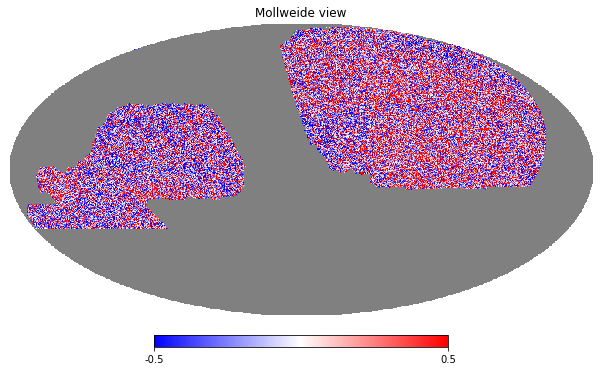

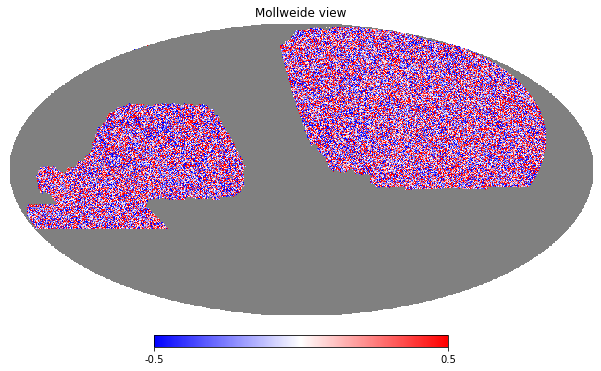

In [15]:
hp.mollview(delta_n, rot=-88, cmap=plt.cm.bwr, min=-0.5, max=0.5)
hp.mollview(delta_nw, rot=-88, cmap=plt.cm.bwr, min=-0.5, max=0.5)

In [16]:
from lssutils.lab import MeanDensity

nbars = {}
nbar = MeanDensity(ngal, frac, mask, syst)
nbar.run()
nbars['null'] = nbar.output

In [17]:
nbars_ = []

for i in range(50):
    
    wnn = nonlinm.ws[i] #makehp(wnn_['hpix'], wnn_['weight'][:, i], nside)

    nbar_ = MeanDensity(ngal, frac, mask, syst, selection=wnn)
    nbar_.run()
    nbars_.append(nbar_.output)
    print('.', end='')

..................................................

In [18]:
2

2

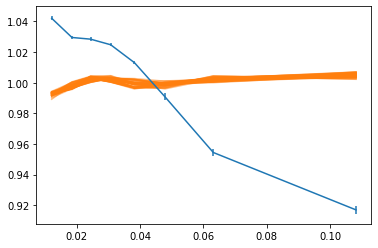

In [19]:
for name, nbar_i in nbars.items():
    plt.errorbar(nbar_i['bin_avg'], nbar_i['nnbar'], yerr=nbar_i['nnbar_err'], label=name)
    
for nbar_i in nbars_:
    plt.plot(nbar_i['bin_avg'], nbar_i['nnbar'], color='C1', alpha=0.5)

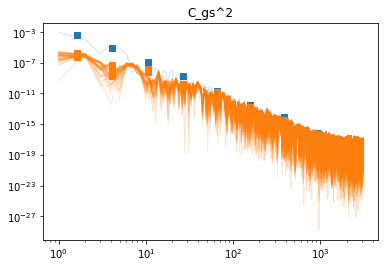

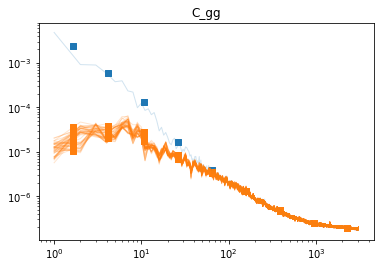

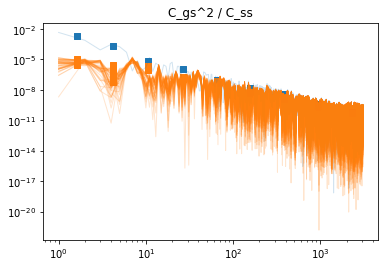

(-1.0, 1.0)

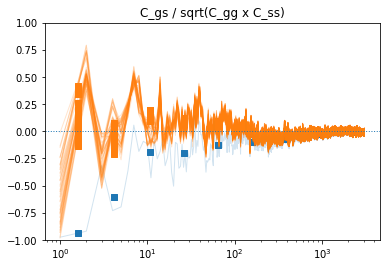

In [20]:
plt.title('C_gs^2')
plot_bin(cl_gs['null']['cl']**2)
for cl_gs_i in cl_gs_:
    plot_bin(cl_gs_i['cl']**2, color='C1')    
plt.xscale('log')
plt.yscale('log')
plt.show()

plt.title('C_gg')
plot_bin(cl_gg['null']['cl'])
for cl_gg_i in cl_gg_:
    plot_bin(cl_gg_i['cl'], color='C1')
plt.xscale('log')
plt.yscale('log')
plt.show()

plt.title('C_gs^2 / C_ss')
plot_bin(cl_gs['null']['cl']**2/cl_ss['cl'])

for cl_gs_i in cl_gs_:
    plot_bin(cl_gs_i['cl']**2/cl_ss['cl'], color='C1')
plt.xscale('log')
plt.yscale('log')
plt.show()

plt.title('C_gs / sqrt(C_gg x C_ss)')
plot_bin(cl_gs['null']['cl']/np.sqrt(cl_gg['null']['cl']*cl_ss['cl']))
i = 0
for cl_gs_i in cl_gs_:
    plot_bin(cl_gs_i['cl']/np.sqrt(cl_gg_[i]['cl']*cl_ss['cl']), color='C1')
    i +=  1
    
# plot_bin(cl_gs['mitig']['cl']/np.sqrt(cl_gg['mitig']['cl']*cl_ss['cl']))
plt.axhline(0.0, ls=':', lw=1)
plt.xscale('log')
# plt.yscale('log')
plt.ylim(-1.0, 1.)

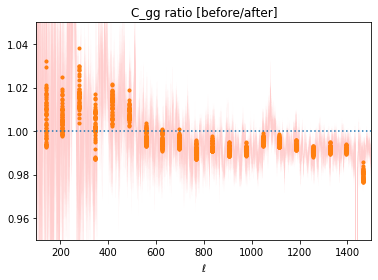

In [53]:
plt.title('C_gg ratio [before/after]')

lbins = np.linspace(100, 1501, 21)
lb, clb = histogram_cell(cl_gg['null']['cl'], bins=lbins)

# plot_bin(cl_gg['null']['cl'])
for cl_gg_i in cl_gg_:
    clb_i = histogram_cell(cl_gg_i['cl'], bins=lbins)[1]
    plt.plot(lb, clb/clb_i, color='C1', ls='None', marker='.')
    plt.plot(cl_gg['null']['cl']/cl_gg_i['cl'], color='C1', lw=1, alpha=0.005)
    
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.xlim(100, 1500.)
plt.ylim(0.95, 1.05)
plt.axhline(1.0, ls=':')
plt.show()

In [54]:
wnn_256 = ft.read('/home/mehdi/data/tanveer/elg_mse_test/nn-weights.fits')

In [55]:
wnn_256['weight'].shape

(302503, 20)

In [57]:
cl_gg_256 = []


for i in range(20):
    
    wnn = makehp(wnn_256['hpix'], wnn_256['weight'][:, i], 256)
    wnn = wnn / wnn[wnn_256['hpix']].mean()
    wnn = wnn.clip(0.5, 2.0)
    wnn_1024 = hp.ud_grade(wnn, 1024)
    
    delta_nw = make_overdensity(ngal, frac, mask, selection_fn=wnn_1024)


    cl_gg_256.append(af(delta_nw, frac, mask))
    print('.', end='')

....................

In [68]:
from lssutils.dataviz import setup_color

In [69]:
setup_color()

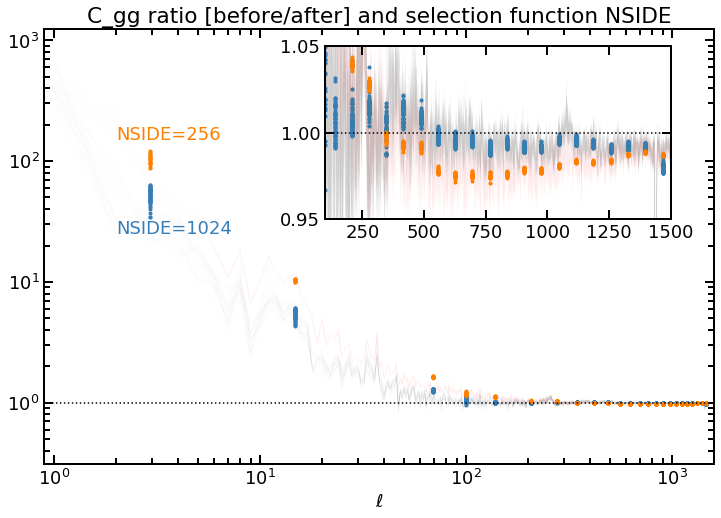

In [88]:
plt.figure(figsize=(12, 8))
plt.title('C_gg ratio [before/after] and selection function NSIDE')

lbins = np.logspace(0, np.log10(100.), 4).tolist() + np.linspace(101, 1501, 21).tolist()
lbins = np.array(lbins)
lb, clb = histogram_cell(cl_gg['null']['cl'], bins=lbins)

# plot_bin(cl_gg['null']['cl'])
colors = ['C0', 'C1']

for j, cl_gg_j in enumerate([cl_gg_, cl_gg_256]):
    
    for cl_gg_i in cl_gg_j:
        clb_i = histogram_cell(cl_gg_i['cl'], bins=lbins)[1]
        plt.plot(lb, clb/clb_i, color=colors[j], ls='None', marker='.')
        plt.plot(cl_gg['null']['cl']/cl_gg_i['cl'], color=colors[j], ls='-', lw=1, alpha=0.005)
    
plt.text(2, 25, 'NSIDE=1024', color='C0')
plt.text(2, 150, 'NSIDE=256', color='C1')
plt.xlim(0.9, 1600)
plt.axhline(1.0, ls=':', color='k')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')

plt.axes([0.45, 0.55, 0.4, 0.3])
for j, cl_gg_j in enumerate([cl_gg_, cl_gg_256]):
    
    for cl_gg_i in cl_gg_j:
        clb_i = histogram_cell(cl_gg_i['cl'], bins=lbins)[1]
        plt.plot(lb, clb/clb_i, color=colors[j], ls='None', marker='.')
        plt.plot(cl_gg['null']['cl']/cl_gg_i['cl'], color=colors[j], ls='-', lw=1, alpha=0.005)
plt.xlim(100, 1500.)
plt.ylim(0.95, 1.05)
plt.axhline(1.0, ls=':', color='k')
plt.savefig('cl_ratio_dr8_nside.png', dpi=300, bbox_inches='tight')

In [ ]:
# use selection functions (e.g., from 256) upsampled for 1024 and remake the plot above
# 
# plot ell^p*C_gs with Gaussian error-bars p = 1 or 2

(-1.0, 1.0)

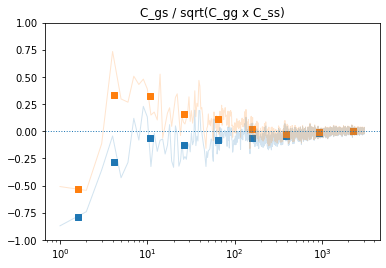

In [15]:
plt.title('C_gs / sqrt(C_gg x C_ss)')
plot_bin(cl_gs['null']/np.sqrt(cl_gg['null']*cl_ss))
plot_bin(cl_gs['mitig']/np.sqrt(cl_gg['mitig']*cl_ss))
plt.axhline(0.0, ls=':', lw=1)
plt.xscale('log')
# plt.yscale('log')
plt.ylim(-1.0, 1.)

In [ ]:
# Can we include the cross power in our loss function? 
# e.g., as a regularization
# it's ok to compute these cross-statistics over mini-batches.
# the term should be something like: C^{t}_gs Cov^-1 C_gs, Cov = 1/[(2el+1)fsky] (C_gg+1/nbar)^2 
# try with a lower NSIDE